In [2]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np

%matplotlib inline



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [42]:
num_epochs = 50
batch_size = 100
l_r = 0.001

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

ds = datasets.MNIST('./data', transform=transforms.ToTensor())

dl = DataLoader(ds, batch_size=batch_size, shuffle=True)



In [55]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 392)
        #self.fc2 = nn.Linear(392, 128)
        self.mu = nn.Linear(392, 32)
        self.logvar = nn.Linear(392,32)
        self.fc3 = nn.Linear(32, 392)
        #self.fc4 = nn.Linear(128, 392)
        self.fc5 = nn.Linear(392, 784)
        
    def encoder(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        log_var = self.logvar(x)
        mean = self.mu(x)
        return log_var, mean
    
    def decoder(self, log_var, mean):
        #########    Reparametrization Trick       ###########
        e = torch.randn(mean.size(0), mean.size(1))
        e = Variable(e)
        latent = mean + e*torch.exp(log_var/2)
        ############################
        x = F.relu(self.fc3(latent))
        #x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.sigmoid(x)
        
    def forward(self, x):
        log_var, mean = self.encoder(x)
        x = self.decoder(log_var, mean)
        return x, log_var, mean
    
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



In [56]:
vae = VAE()
adam_optimize = torch.optim.Adam(vae.parameters(), lr=l_r)

In [57]:
def loss_calc(out, inp, mean, log_var):
    bce = F.binary_cross_entropy(out, inp, size_average=False)
    kl_divergence = torch.sum(0.5*(mean.pow(2) + log_var.exp() - 1 - log_var))
    return bce + kl_divergence

('Loss after Epoch #{} =  {.4f}', 1, -1437593.625)
('Loss after Epoch #{} =  {.4f}', 2, -1398677.0)
('Loss after Epoch #{} =  {.4f}', 3, -1446720.125)
('Loss after Epoch #{} =  {.4f}', 4, -1451732.25)
('Loss after Epoch #{} =  {.4f}', 5, -1490038.75)
('Loss after Epoch #{} =  {.4f}', 6, -1491346.375)
('Loss after Epoch #{} =  {.4f}', 7, -1542780.875)
('Loss after Epoch #{} =  {.4f}', 8, -1541302.75)
('Loss after Epoch #{} =  {.4f}', 9, -1507277.5)
('Loss after Epoch #{} =  {.4f}', 10, -1552791.375)
('Loss after Epoch #{} =  {.4f}', 11, -1548031.125)
('Loss after Epoch #{} =  {.4f}', 12, -1589907.625)
('Loss after Epoch #{} =  {.4f}', 13, -1557169.625)
('Loss after Epoch #{} =  {.4f}', 14, -1570838.875)
('Loss after Epoch #{} =  {.4f}', 15, -1577083.625)
('Loss after Epoch #{} =  {.4f}', 16, -1587572.0)
('Loss after Epoch #{} =  {.4f}', 17, -1555244.5)
('Loss after Epoch #{} =  {.4f}', 18, -1580681.25)
('Loss after Epoch #{} =  {.4f}', 19, -1570131.625)
('Loss after Epoch #{} =  {.4f}',

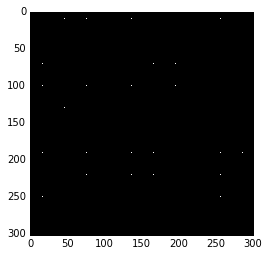

In [58]:
for epoch in range(1, num_epochs+1):
    for d in dl:
        i, l = d
        i = Variable(i.view(i.size(0), -1))
        o, log_var, mean = vae(i)
        loss_val = loss_calc(o, i, mean, log_var)
        adam_optimize.zero_grad()
        loss_val.backward()
        adam_optimize.step()
    print("Loss after Epoch #{} =  {.4f}", epoch, loss_val.data[0])
    if epoch%10==0:
        out = o.data
        out = out.view(out.size(0), 1, 28, 28)
        show(make_grid(out, nrow=10,normalize=True))

        
torch.save(vae.state_dict(), './vse.pth')